<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Aanlysis
* Iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta

import os 
import re 

from functools import reduce
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'mock_sales_data.csv',
 'mall_customers.csv',
 'scanner_data.csv',
 'online_retail.xlsx',
 '1_order_payments_dataset.csv',
 'groceries.csv',
 'sample-sales-data.csv',
 'ecommerce-data.csv',
 'sales_vs_discount.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'sales.csv',
 '1_customers_dataset.csv',
 '1_orders_dataset.csv',
 'test.csv',
 'sales_data_with_stores.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sample_data']

In [10]:
df = pd.read_csv('scanner_data.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [11]:
df.columns = [a.lower() for a in df.columns]
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [12]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.sales_amount
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,month,rev
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,6.88


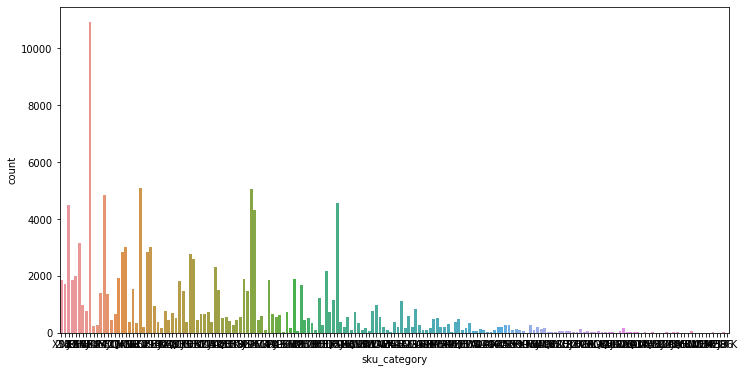

In [16]:
plt.figure(figsize = [12,6])
sns.countplot(data = df, x = 'sku_category')

In [17]:
df = df.groupby(['customer_id', 'date', 'month'])['rev'].sum().reset_index().rename(columns = {'customer_id':'id'})
df.head()

,id,date,month,rev
0,1,2016-01-22,2016-01-01,16.29
1,2,2016-03-24,2016-03-01,7.77
2,2,2016-06-19,2016-06-01,15.00
3,3,2016-02-01,2016-02-01,19.08
4,4,2016-09-11,2016-09-01,26.60


In [19]:
info_m = df.groupby(['id','month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').reset_index().sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,1,0.00
1,2,0.00
2,3,0.00
3,4,6.69
4,5,0.00


In [20]:
info_f = df.groupby(['id','month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').reset_index().sort_values(['id','freq'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,1,1.0
1,2,2.0
2,3,1.0
3,4,2.0
4,5,4.0


In [21]:
date_max = df['date'].max() + pd.offsets.MonthEnd(0)
date_max

Timestamp('2016-12-31 00:00:00')

In [22]:
info_r = df.groupby(['id']).agg({'date' : lambda x : (date_max - x.max())}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()

,id,recency
0,1,344
1,2,195
2,3,334
3,4,54
4,5,120


In [29]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info = info.assign(
    r = pd.qcut(info.recency, 5, list('54321')).astype(int),
    f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')).astype(int),
    m = pd.qcut(info.money.rank(method = 'first'), 5, list('12345')).astype(int)
)
info.head()

,id,recency,freq,money,r,f,m
0,1,344,1.0,0.00,1,1,1
1,2,195,2.0,0.00,2,3,1
2,3,334,1.0,0.00,1,1,1
3,4,54,2.0,6.69,4,3,4
4,5,120,4.0,0.00,3,5,1


In [31]:
cnt= info.groupby(['r', 'f', 'm']).agg({'recency':'mean', 'freq':'mean','money':'mean'}).reset_index().sort_values(['r','f','m'])
cnt.head()

,r,f,m,recency,freq,money
0,1,1,1,316.475429,1.0,0.0
1,1,1,2,314.291822,1.0,0.0
2,1,2,2,313.855301,1.0,0.0
3,1,2,3,303.114187,1.0,0.0
4,1,3,1,302.303303,2.0,0.0


In [32]:
import plotly.express as ex

In [35]:
ex.scatter_3d( cnt, x = 'r', y = 'f', z = 'm', size = 'recency')

# Iterator

In [41]:
def get_score(names) :

  uniques, counts = np.unique(names, return_counts = True)
  uniques = dict(zip(uniques, counts))

  res = list()

  for k, v in uniques.items() :

    m = np.random.randint(30, 80, 1)
    s = np.random.randint(5, 10, 1)
    score = np.random.normal(m, s, v) 

    temp = pd.DataFrame({'name' : np.repeat(k, v), 'score' : score})
    res.append(temp)
  
  res = pd.concat(res).reset_index().drop('index', axis = 1)

  return res

names = np.random.choice(['park', 'kim', 'yoo', 'oh', 'roh'], 1000, replace = True)

res = get_score(names)
res.head()

,name,score
0,kim,58.285510
1,kim,79.189986
2,kim,78.646192
3,kim,81.598656
4,kim,79.520499


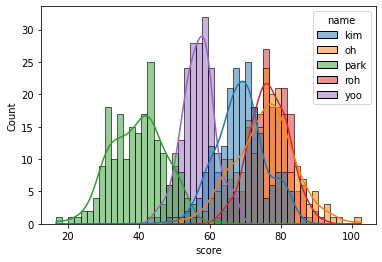

In [42]:
sns.histplot(data = res, x = 'score', hue = 'name', kde = True, bins = 50)